### Importing dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
import contractions
import unicodedata
import spacy
from sklearn import metrics

%matplotlib inline

In [2]:
df_train = pd.read_csv('train-dataset.csv')
df_test = pd.read_csv('hold-out.csv')

In [5]:
df_train.head()

,comment,offensive,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,nonsense kiss geek say true account terminate,1,1,0,0,0,0,0
1,please not vandalize page edit w merwin contin...,0,0,0,0,0,0,0
2,point interest remove point interest section a...,0,0,0,0,0,0,0
3,ask nationality racial offence wow not aware b...,0,0,0,0,0,0,0
4,reader not go say ethereal vocal style dark ly...,0,0,0,0,0,0,0


In [8]:
df_test.head()

,comment,offensive,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,revert constitute vandalism revert please not ...,0,0,0,0,0,0,0
1,call someone petty tyrant personal attack kind...,0,0,0,0,0,0,0
2,article manage become ga thank work hope use e...,0,0,0,0,0,0,0
3,hey mr troll not learn word vandalism mean bet...,1,1,0,1,0,0,0
4,miscellaneous section look like basically list...,0,0,0,0,0,0,0


In [14]:
df_test.isnull().sum()

comment          9
offensive        0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
df_test = df_test[~(df_test['comment'].isnull())]

### Load and View Dataset

In [10]:
X_train = df_train['comment']
X_test = df_test['comment'][:10000]

y_train = df_train['offensive']
y_test = df_test['offensive'][:10000]

### Feature Engineering with word embeddings

In [11]:
%%time

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(binary=False, min_df=5, max_df=1.0)

vect_train_matrix = vect.fit_transform(X_train)
vect_test_matrix = vect.transform(X_test)

CPU times: user 895 ms, sys: 19.4 ms, total: 915 ms
Wall time: 917 ms


In [12]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0)

tfid_train_matrix = tfid.fit_transform(X_train)
tfid_test_matrix = tfid.transform(X_test)

CPU times: user 798 ms, sys: 19.1 ms, total: 817 ms
Wall time: 822 ms


In [87]:
print("Bag of words training dataset 1-gram features" , vect_train_matrix.shape[1])
print("Bag of words test dataset 1-gram features" , vect_test_matrix.shape[1])

print ("Tfidf training dataset 1-gram features" , tfid_train_matrix.shape[1])
print ("Tfidd of words training dataset 1-gram features" , tfid_train_matrix.shape[1])

Bag of words training dataset 1-gram features 7809
Bag of words test dataset 1-gram features 7809
Tfidf training dataset 1-gram features 7809
Tfidd of words training dataset 1-gram features 7809


### Training Logistic Regression Model

Before we start training the models we need to identify our main evaluation metrics. **Our goal here is to label the offensive comments correctly.** So, this model requires the **least possible False Negative labels** and checking accuracy by itself is not enoguh to evaluate the performance of the model. In addition to accuracy we need to evaluate the rate of False Negatives by checking **Recall.**  

In [13]:
%%time

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs')



CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 25 µs


In [14]:
%%time

lr.fit(vect_train_matrix, y_train)

lr_bow_prediction = lr.predict(vect_test_matrix)

print (metrics.accuracy_score(y_test , lr_bow_prediction))

print (metrics.confusion_matrix(y_test , lr_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

0.9486
[[8886  103]
 [ 411  600]]
F1 score:  0.7001166861143523
Precision score:  0.8534850640113798
Recall score:  0.5934718100890207
CPU times: user 2.28 s, sys: 21.3 ms, total: 2.3 s
Wall time: 619 ms


In [15]:
%%time

lr.fit(tfid_train_matrix, y_train)

lr_tfid_prediction = lr.predict(tfid_test_matrix)

print (metrics.accuracy_score(y_test , lr_tfid_prediction))

print (metrics.confusion_matrix(y_test , lr_tfid_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_tfid_prediction))

print("Precision score: " , metrics.precision_score(y_test , lr_tfid_prediction))

print("Recall score: " , metrics.recall_score(y_test , lr_tfid_prediction))

0.9431
[[8970   19]
 [ 550  461]]
F1 score:  0.6183769282360831
Precision score:  0.9604166666666667
Recall score:  0.4559841740850643
CPU times: user 784 ms, sys: 3.5 ms, total: 788 ms
Wall time: 205 ms


### Comparing performance of Logistic Regression with Bag of Words and Tf-idf shows Bag of Words performs better with Logistice Regression. Continuing optimizing of Logistic Regression with Bag of words. 

In [16]:
%%time

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= .5) , lr)

smote_model = smote_pipeline.fit(vect_train_matrix , y_train)

smote_predict = smote_model.predict(vect_test_matrix)

print (metrics.accuracy_score(y_test , smote_predict))

print (metrics.confusion_matrix(y_test , smote_predict))

print("F1 score: ", metrics.f1_score(y_test , smote_predict))

print("Precision score: " , metrics.precision_score(y_test , smote_predict))

print("Recall score: " , metrics.recall_score(y_test , smote_predict))

0.8939
[[8209  780]
 [ 281  730]]
F1 score:  0.5791352637842127
Precision score:  0.48344370860927155
Recall score:  0.722057368941642
CPU times: user 7.5 s, sys: 76.1 ms, total: 7.58 s
Wall time: 3.92 s


### Imbalance datasets can lead to false predictions and false sense of accuracy. One of the approaches to balance the classes is by increasing the minority or decreasing the majority samples in our model. Here we chose to oversample the class 1 or offensive comments via  SMOTE. As you see we have a significant improvement on Recall and number of False Negative labels. 

### Training Random Forest Model

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

rfc_bow_pipe = make_pipeline(vect , rfc)

rfc_bow_pipe.fit(X_train , y_train)

rfc_bow_prediction = rfc_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , rfc_bow_prediction))

print (metrics.confusion_matrix(y_test , rfc_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , rfc_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , rfc_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , rfc_bow_prediction))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.9488
[[8891   98]
 [ 414  597]]
F1 score:  0.6998827667057443
Precision score:  0.8589928057553957
Recall score:  0.5905044510385756


### Hyper-parameter tuning to optimize Random Forest through Randoomized Search

In [111]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [113]:
%%time

from sklearn.model_selection import RandomizedSearchCV

random = RandomizedSearchCV(rfc , param_grid , n_iter = 3 , cv = 3)

random.fit(vect_train_matrix , y_train)

CPU times: user 4min 43s, sys: 859 ms, total: 4min 44s
Wall time: 4min 45s


In [115]:
random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [21]:
%%time

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)


rfc_bow_pipe = make_pipeline(vect , rfc)

rfc_bow_pipe.fit(X_train , y_train)

rfc_bow_prediction = rfc_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , rfc_bow_prediction))

print (metrics.confusion_matrix(y_test , rfc_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , rfc_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , rfc_bow_prediction))

print ("Recall score: " , metrics.recall_score(y_test , rfc_bow_prediction))

0.9497
[[8955   34]
 [ 469  542]]
F1 score:  0.6830497794580971
Precision score:  0.9409722222222222
Recall score:  0.5361028684470821
CPU times: user 51.4 s, sys: 192 ms, total: 51.6 s
Wall time: 51.7 s


In [22]:
%%time

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)


rfc_tfid_pipe = make_pipeline(tfid , rfc)

rfc_tfid_pipe.fit(X_train , y_train)

rfc_tfid_prediction = rfc_tfid_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , rfc_tfid_prediction))

print (metrics.confusion_matrix(y_test , rfc_tfid_prediction))

print("F1 score: ", metrics.f1_score(y_test , rfc_tfid_prediction))

print("Precision score: " , metrics.precision_score(y_test , rfc_tfid_prediction))

print("Recall score: " , metrics.recall_score(y_test , rfc_tfid_prediction))

0.9523
[[8930   59]
 [ 418  593]]
F1 score:  0.7131689717378232
Precision score:  0.9095092024539877
Recall score:  0.5865479723046488
CPU times: user 1min 12s, sys: 201 ms, total: 1min 12s
Wall time: 1min 13s


### Tuned Random Forest model works better with Tf-idf. Yet, in the best case it dooesn't out perform Logistic Regression. 

### Training Naïve Bayes Model

In [197]:
import scipy as sp

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb_bow_pipe = make_pipeline(vect , nb)

param_grid= {
    'multinomialnb__alpha' : sp.stats.uniform(scale = 1)
}

nb_bow_pipe = make_pipeline(vect , nb)

random = RandomizedSearchCV(nb_bow_pipe , param_grid , cv = 5 , scoring = 'f1')

random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), p..., vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a482872b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [198]:
random.best_score_

0.7154603178966132

In [199]:
random.best_params_

{'multinomialnb__alpha': 0.7017405572309684}

In [26]:
%%time

nb = MultinomialNB(alpha= 0.701)

nb_bow_pipe = make_pipeline(vect , nb)

nb_bow_pipe.fit(X_train , y_train)

nb_bow_predction = nb_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , nb_bow_predction))

print (metrics.confusion_matrix(y_test , nb_bow_predction))

print("F1 score: ", metrics.f1_score(y_test , nb_bow_predction))

print("Precision score: " , metrics.precision_score(y_test , nb_bow_predction))

print("Recall score: " , metrics.recall_score(y_test , nb_bow_predction))

0.9446
[[8767  222]
 [ 332  679]]
F1 score:  0.7102510460251047
Precision score:  0.753607103218646
Recall score:  0.6716122650840751
CPU times: user 852 ms, sys: 18.3 ms, total: 871 ms
Wall time: 870 ms


In [146]:
%%time

nb = MultinomialNB(alpha= 0.701)

nb_tfid_pipe = make_pipeline(tfid , nb)

nb_tfid_pipe.fit(X_train , y_train)

nb_tfid_predction = nb_tfid_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , nb_tfid_predction))

print (metrics.confusion_matrix(y_test , nb_tfid_predction))

print("F1 score: ", metrics.f1_score(y_test , nb_tfid_predction))

print("Precision score: " , metrics.precision_score(y_test , nb_tfid_predction))

print("Recall score: " , metrics.recall_score(y_test , nb_tfid_predction))

0.938
[[8975   14]
 [ 606  405]]
F1 score:  0.5664335664335665
Precision score:  0.9665871121718377
Recall score:  0.40059347181008903
CPU times: user 826 ms, sys: 45.2 ms, total: 871 ms
Wall time: 872 ms


### Optimized Naïve Bayes with alpha = 0.715 works better than Random Forest, still doesnt out perform Logistic Regression. 

### Training XGBoost

In [223]:
%%time

from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.01,n_estimators=200 )

xgb_bow_pipe = make_pipeline(vect , xgb)

xgb_bow_pipe.fit(X_train , y_train)

xgb_bow_prediction = xgb_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , xgb_bow_prediction))

print (metrics.confusion_matrix(y_test , xgb_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , xgb_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , xgb_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , xgb_bow_prediction))

0.9233
[[8979   10]
 [ 757  254]]
F1 score:  0.3984313725490196
Precision score:  0.9621212121212122
Recall score:  0.2512363996043521


### Without hyper-parameter tuning, model performs poorly. We have very high number of False Negative. 

### Hyper-parameter tuning to optimize XGBoost through Randoomized Search

P.S: The run time was unexpectedly high, so I decided to split the process into smaller steps, as each step performs tunnign on one parameter. 

In [302]:
param_grid = {"xgbclassifier__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "xgbclassifier__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ],
 "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "xgbclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [217]:
%%time

param_grid = {
    "xgbclassifier__learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 }

xgb = XGBClassifier()

xgb_bow_pipe = make_pipeline(vect , xgb)

grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'recall')

grid.fit(X_train , y_train)

CPU times: user 2min 23s, sys: 548 ms, total: 2min 24s
Wall time: 2min 24s


In [218]:
grid.best_params_

{'xgbclassifier__learning_rate': 0.3}

In [219]:
param_grid = {
 "xgbclassifier__max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15] }

xgb = XGBClassifier(learning_rate=0.3)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'recall')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__max_depth': [3, 4, 5, 6, 8, 10, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [220]:
grid.best_score_

0.5215555840110736

In [221]:
grid.best_params_

{'xgbclassifier__max_depth': 15}

In [183]:
param_grid = {
    "xgbclassifier__min_child_weight" : [ 1, 3, 5, 7 ]}

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'f1')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__min_child_weight': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [184]:
grid.score

0.5762104722959444

In [185]:
param_grid = {
 "xgbclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ] }

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'f1')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [186]:
grid.best_score_

0.5700055338712294

In [187]:
param_grid = {
 "xgbclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15)
grid = GridSearchCV(xgb_bow_pipe , param_grid , cv= 5 , scoring= 'recall')

grid.fit(X_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbclassifier__colsample_bytree': [0.3, 0.4, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [188]:
grid.best_score_

0.5656195544254697

In [27]:
%%time

from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

xgb_tfid_pipe = make_pipeline(tfid , xgb)

xgb_tfid_pipe.fit(X_train , y_train)

xgb_tfid_prediction = xgb_tfid_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , xgb_tfid_prediction))

print (metrics.confusion_matrix(y_test , xgb_tfid_prediction))

print("F1 score: ", metrics.f1_score(y_test , xgb_tfid_prediction))

print("Precision score: " , metrics.precision_score(y_test , xgb_tfid_prediction))

print ("Recall score: ", metrics.recall_score(y_test , xgb_tfid_prediction))

0.9537
[[8915   74]
 [ 389  622]]
F1 score:  0.7287639132981838
Precision score:  0.8936781609195402
Recall score:  0.6152324431256182
CPU times: user 50.8 s, sys: 97.6 ms, total: 50.9 s
Wall time: 51 s


In [28]:
%%time

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

xgb_bow_pipe = make_pipeline(vect , xgb)

xgb_bow_pipe.fit(X_train , y_train)

xgb_bow_prediction = xgb_bow_pipe.predict(X_test)

print (metrics.accuracy_score(y_test , xgb_bow_prediction))

print (metrics.confusion_matrix(y_test , xgb_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , xgb_bow_prediction))

print("Precision score: " , metrics.precision_score(y_test , xgb_bow_prediction))

print("Recall score: " , metrics.recall_score(y_test , xgb_bow_prediction))

0.9518
[[8889  100]
 [ 382  629]]
F1 score:  0.7229885057471263
Precision score:  0.8628257887517147
Recall score:  0.6221562809099901
CPU times: user 40.8 s, sys: 101 ms, total: 40.9 s
Wall time: 41 s


### We see a great improvement after tunning 3 parameters "learning_rate", "max_depth" and "n_estimators". However, model still doesn't out perform Logistic Regression. 

## Trainign the Stacked Models on Bag of Words and TF-IDS

In [317]:
%%time
from sklearn.ensemble import VotingClassifier

nb = MultinomialNB(alpha= 0.701)

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= 0.72, k_neighbors = 40 ,kind = 'borderline2') , lr)

eclf1 = VotingClassifier(estimators=[('smote', smote_pipeline), ('nb', nb)] , voting='hard' , 
                        weights=[20 , 1])

eclf1.fit(vect_train_matrix , y_train)

eclf1_predict = eclf1.predict(vect_test_matrix)

print (metrics.accuracy_score(y_test , eclf1_predict))

print (metrics.confusion_matrix(y_test , eclf1_predict))

print("F1 score: ", metrics.f1_score(y_test , eclf1_predict))

print("Precision score: " , metrics.precision_score(y_test , eclf1_predict))

print("Recall score: " , metrics.recall_score(y_test , eclf1_predict))


0.8612
[[7877 1112]
 [ 276  735]]
F1 score:  0.5143456962911127
Precision score:  0.3979426096372496
Recall score:  0.7270029673590505
CPU times: user 14 s, sys: 508 ms, total: 14.5 s
Wall time: 8.54 s


In [316]:
%%time
from sklearn.ensemble import VotingClassifier

nb = MultinomialNB(alpha= 0.701)

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= 0.95 , k_neighbors = 40 ,kind = 'borderline2') , lr)

eclf2 = VotingClassifier(estimators=[('smote', smote_pipeline), ('nb', nb)] , voting='soft' , 
                        weights=[50 , 1])

eclf2.fit(tfid_train_matrix , y_train)

eclf2_predict = eclf2.predict(tfid_test_matrix)

print (metrics.accuracy_score(y_test , eclf2_predict))

print (metrics.confusion_matrix(y_test , eclf2_predict))

print("F1 score: ", metrics.f1_score(y_test , eclf2_predict))

print("Precision score: " , metrics.precision_score(y_test , eclf2_predict))

print("Recall score: " , metrics.recall_score(y_test , eclf2_predict))

0.9341
[[8515  474]
 [ 185  826]]
F1 score:  0.7148420597144094
Precision score:  0.6353846153846154
Recall score:  0.8170128585558852
CPU times: user 14.7 s, sys: 564 ms, total: 15.3 s
Wall time: 10.8 s


In [315]:
%%time

nb = MultinomialNB(alpha= 0.701)

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= 0.95 ,  k_neighbors = 40 , kind = 'borderline2') , lr)

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)

eclf4 = VotingClassifier(estimators=[('smote', smote_pipeline), ('nb', nb) , ('rfc' , rfc)] , voting='hard' , 
                        weights=[20 , 3 , 1])

eclf4.fit(vect_train_matrix , y_train)

eclf4_predict = eclf4.predict(vect_test_matrix)

print (metrics.accuracy_score(y_test , eclf4_predict))

print (metrics.confusion_matrix(y_test , eclf4_predict))

print("F1 score: ", metrics.f1_score(y_test , eclf4_predict))

print("Precision score: " , metrics.precision_score(y_test , eclf4_predict))

print("Recall score: " , metrics.recall_score(y_test , eclf4_predict))

0.8505
[[7759 1230]
 [ 265  746]]
F1 score:  0.49949782390358216
Precision score:  0.3775303643724696
Recall score:  0.7378832838773491
CPU times: user 1min 17s, sys: 818 ms, total: 1min 18s
Wall time: 1min 12s


In [300]:
%%time

nb = MultinomialNB(alpha= 0.701)

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= 0.95) , lr)

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)

eclf3 = VotingClassifier(estimators=[('smote', smote_pipeline), ('nb', nb) , ('rfc' , rfc)] , voting='hard' , 
                        weights=[40 , 5 , 1])

eclf3.fit(tfid_train_matrix , y_train)

eclf3_predict = eclf3.predict(tfid_test_matrix)

print (metrics.accuracy_score(y_test , eclf3_predict))

print (metrics.confusion_matrix(y_test , eclf3_predict))

print("F1 score: ", metrics.f1_score(y_test , eclf3_predict))

print("Precision score: " , metrics.precision_score(y_test , eclf3_predict))

print("Recall score: " , metrics.recall_score(y_test , eclf3_predict))

0.8985
[[8200  789]
 [ 226  785]]
F1 score:  0.6073500967117988
Precision score:  0.49872935196950446
Recall score:  0.7764589515331355
CPU times: user 1min 24s, sys: 389 ms, total: 1min 25s
Wall time: 1min 22s


In [235]:
%%time
from sklearn.ensemble import VotingClassifier

#nb = MultinomialNB(alpha= 0.701)

xgb = XGBClassifier(learning_rate=0.3 , max_depth= 15 , n_estimators= 200 )

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= 0.7) , lr)

eclf5 = VotingClassifier(estimators=[('smote', smote_pipeline), ('xgb', xgb)] , voting='soft' , 
                        weights=[20 , 1])

eclf5.fit(avg_wv_train_features , y_train)

eclf5_predict = eclf5.predict(avg_wv_test_features)

print (metrics.accuracy_score(y_test , eclf5_predict))

print (metrics.confusion_matrix(y_test , eclf5_predict))

print("F1 score: ", metrics.f1_score(y_test , eclf5_predict))

print("Precision score: " , metrics.precision_score(y_test , eclf5_predict))

print("Recall score: " , metrics.recall_score(y_test , eclf5_predict))

0.8991
[[8232  757]
 [ 252  759]]
F1 score:  0.6007123070834983
Precision score:  0.5006596306068601
Recall score:  0.7507418397626113
CPU times: user 3min 1s, sys: 508 ms, total: 3min 1s
Wall time: 2min 38s


### Best Recall was attained from training the stacked model of Naive Bayes and SMOTE on TF-IDF

## Trainign the Stacked Models on Word2Vec

In [217]:
import gensim
tokenized_train = [nltk.word_tokenize(t) for t in X_train]
tokenized_test = [nltk.word_tokenize(t) for t in X_test]

num_features = 256 

w2v_model_train = gensim.models.Word2Vec(tokenized_train, size= num_features, window=150,
                                   min_count=10, sample=1e-3, workers=16)


In [249]:
def averaged_word2vec_vectorizer(corpus , model , num_features):
    vocabulary = set (model.wv.index2word)
    
    def average_word_vectors(words, model , vocabulary , num_features):
        feature_vector = np.zeros((num_features) , dtype = 'float64')
        nwords = 0
        
        for word in words : 
            if word in vocabulary:
                nwords += 1 
                feature_vector = np.add(feature_vector , model.wv[word])
        if nwords: 
            feature_vector = np.divide(feature_vector , nwords)
            
        return feature_vector
    features = [average_word_vectors(tokenized_sentence , model, vocabulary , num_features) 
                for tokenized_sentence in corpus]
    return np.array(features)


In [250]:
avg_wv_train_features = averaged_word2vec_vectorizer(corpus= tokenized_train , model = w2v_model, num_features= num_features)

avg_wv_test_features = averaged_word2vec_vectorizer(corpus= tokenized_test , model = w2v_model , num_features= num_features)


In [313]:
%%time

smote_w2v_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= .95 , k_neighbors = 40 , kind = 'borderline2') , lr )

smote_w2v_model = smote_w2v_pipeline.fit(avg_wv_train_features , y_train )

smote_w2v_predict = smote_w2v_model.predict(avg_wv_test_features)

print (metrics.accuracy_score(y_test , smote_w2v_predict))

print (metrics.confusion_matrix(y_test , smote_w2v_predict))

print("F1 score: ", metrics.f1_score(y_test , smote_w2v_predict))

print("Precision score: " , metrics.precision_score(y_test , smote_w2v_predict))

print("Recall score: " , metrics.recall_score(y_test , smote_w2v_predict))

0.8229
[[7359 1630]
 [ 141  870]]
F1 score:  0.4955853033323839
Precision score:  0.348
Recall score:  0.8605341246290801
CPU times: user 52.2 s, sys: 623 ms, total: 52.8 s
Wall time: 25.9 s


In [282]:
%%time

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= 0.95 , k_neighbors = 40) , lr)

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)

eclf5 = VotingClassifier(estimators=[('smote', smote_pipeline),('rfc' , rfc)] , voting='soft' , 
                        weights=[40 ,1])

eclf5.fit(avg_wv_train_features , y_train)

eclf5_predict = eclf5.predict(avg_wv_test_features)

print (metrics.accuracy_score(y_test , eclf5_predict))

print (metrics.confusion_matrix(y_test , eclf5_predict))

print("F1 score: ", metrics.f1_score(y_test , eclf5_predict))

print("Precision score: " , metrics.precision_score(y_test , eclf5_predict))

print("Recall score: " , metrics.recall_score(y_test , eclf5_predict))

0.8721
[[7903 1086]
 [ 193  818]]
F1 score:  0.5612349914236706
Precision score:  0.42962184873949577
Recall score:  0.8090999010880316
CPU times: user 5min 47s, sys: 1.15 s, total: 5min 48s
Wall time: 5min 20s


### The best recall was attained from training Logistic Regression- SMOTE on Word2Vec

## Trainign the Stacked models on FastText

In [295]:
fast_model = gensim.models.FastText(tokenized_train)


In [296]:
def averaged_FastText_vectorizer(corpus , model , num_features):
    vocabulary = set (model.wv.index2word)
    
    def average_word_vectors(words, model , vocabulary , num_features):
        feature_vector = np.zeros((num_features) , dtype = 'float64')
        nwords = 0
        
        for word in words : 
            if word in vocabulary:
                nwords += 1 
                feature_vector = np.add(feature_vector , model.wv[word])
        if nwords: 
            feature_vector = np.divide(feature_vector , nwords)
            
        return feature_vector
    features = [average_word_vectors(tokenized_sentence , model, vocabulary , num_features) 
                for tokenized_sentence in corpus]
    return np.array(features)

In [304]:
avg_ft_train_features = averaged_FastText_vectorizer(corpus= tokenized_train , model = fast_model, num_features= 100)

avg_ft_test_features = averaged_FastText_vectorizer(corpus= tokenized_test , model = fast_model , num_features= 100)


In [305]:
%%time

smote_ft_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= .95 , k_neighbors = 40) , lr )

smote_ft_model = smote_ft_pipeline.fit(avg_ft_train_features , y_train )

smote_ft_predict = smote_ft_model.predict(avg_ft_test_features)

print (metrics.accuracy_score(y_test , smote_ft_predict))

print (metrics.confusion_matrix(y_test , smote_ft_predict))

print("F1 score: ", metrics.f1_score(y_test , smote_ft_predict))

print("Precision score: " , metrics.precision_score(y_test , smote_ft_predict))

print("Recall score: " , metrics.recall_score(y_test , smote_ft_predict))

0.8635
[[7841 1148]
 [ 217  794]]
F1 score:  0.537758211987809
Precision score:  0.40885684860968075
Recall score:  0.7853610286844708
CPU times: user 11.1 s, sys: 140 ms, total: 11.2 s
Wall time: 2.29 s


In [312]:
%%time

smote_ft_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= .95 , k_neighbors = 40 , kind = 'borderline2' ) , lr )

smote_ft_model = smote_ft_pipeline.fit(avg_ft_train_features , y_train )

smote_ft_predict = smote_ft_model.predict(avg_ft_test_features)

print (metrics.accuracy_score(y_test , smote_ft_predict))

print (metrics.confusion_matrix(y_test , smote_ft_predict))

print("F1 score: ", metrics.f1_score(y_test , smote_ft_predict))

print("Precision score: " , metrics.precision_score(y_test , smote_ft_predict))

print("Recall score: " , metrics.recall_score(y_test , smote_ft_predict))

0.8232
[[7380 1609]
 [ 159  852]]
F1 score:  0.4907834101382488
Precision score:  0.3462007314099959
Recall score:  0.8427299703264095
CPU times: user 17.6 s, sys: 150 ms, total: 17.8 s
Wall time: 7.14 s


In [318]:
%%time

smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy= 0.95 , k_neighbors = 40 , kind = 'borderline2') , lr)

rfc = RandomForestClassifier(n_estimators= 800, min_samples_split = 10,min_samples_leaf = 2,
                             max_features = 'auto' , max_depth = None, bootstrap = False)

eclf6 = VotingClassifier(estimators=[('smote', smote_pipeline),('rfc' , rfc)] , voting='soft' , 
                        weights=[40 ,1])

eclf6.fit(avg_ft_train_features , y_train)

eclf6_predict = eclf6.predict(avg_ft_test_features)

print (metrics.accuracy_score(y_test , eclf6_predict))

print (metrics.confusion_matrix(y_test , eclf6_predict))

print("F1 score: ", metrics.f1_score(y_test , eclf6_predict))

print("Precision score: " , metrics.precision_score(y_test , eclf6_predict))

print("Recall score: " , metrics.recall_score(y_test , eclf6_predict))

0.83
[[7461 1528]
 [ 172  839]]
F1 score:  0.4967436352871522
Precision score:  0.35445711871567387
Recall score:  0.8298714144411474
CPU times: user 3min 56s, sys: 814 ms, total: 3min 57s
Wall time: 3min 45s


### We reached our highest Recall values after training Logistic Regression-SMOTE on Word2Vec. It seems we found the winner model for our problem after all!

## Comparing models visually 

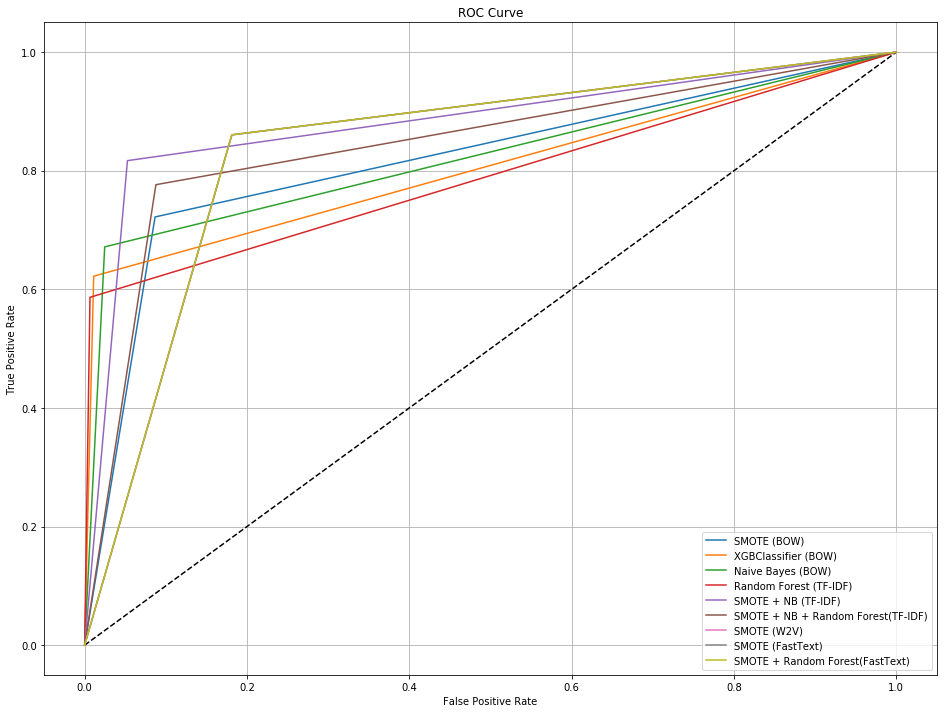

In [320]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_fp, lr_tpr, lr_thresholds  = roc_curve(y_test, smote_predict)
svm_fp, svm_tpr, svm_thresholds  = roc_curve(y_test, xgb_bow_prediction)
nb_fp, nb_tpr, nb_thresholds  = roc_curve(y_test, nb_bow_predction)
rf_fp, rf_tpr, rf_thresholds  = roc_curve(y_test, rfc_tfid_prediction)
#bow_com_fp, bow_com_tpr, bow_com_thresholds  = roc_curve(y_test, eclf1_predict)
tf_com_fp, tf_com_tpr, tf_com_thresholds  = roc_curve(y_test, eclf2_predict)
tf_3w_fp, tf_3w_tpr, tf_3w_thresholds  = roc_curve(y_test, eclf3_predict)
#bow_3w_fp, bow_3w_tpr, bow_3w_thresholds  = roc_curve(y_test, eclf4_predict)
w2v_smote_fp, w2v_smote_tpr, w2v_smote_thresholds = roc_curve(y_test, smote_w2v_predict)
ft_smote_fp, ft_smote_tpr, ft_smote_thresholds = roc_curve(y_test, smote_ft_predict)
ft_com_fp, ft_smote_tpr, ft_smote_thresholds = roc_curve(y_test, eclf6_predict)


plt.figure(figsize= (16 , 12))
plt.plot([0,1], [0,1], 'k--' , )
plt.plot(lr_fp, lr_tpr, label='SMOTE (BOW)')
plt.plot(svm_fp, svm_tpr, label='XGBClassifier (BOW)')
plt.plot(nb_fp, nb_tpr, label='Naive Bayes (BOW)')
plt.plot(rf_fp, rf_tpr, label='Random Forest (TF-IDF)')
#plt.plot(bow_com_fp, bow_com_tpr, label='SMOTE + NB (BOW)')
plt.plot(tf_com_fp, tf_com_tpr, label='SMOTE + NB (TF-IDF)')
plt.plot(tf_3w_fp, tf_3w_tpr, label='SMOTE + NB + Random Forest(TF-IDF)')
#plt.plot(bow_3w_fp, bow_3w_tpr, label='SMOTE + NB + Random Forest(BOW)')
plt.plot(w2v_smote_fp, w2v_smote_tpr, label='SMOTE (W2V)')
plt.plot(w2v_smote_fp, w2v_smote_tpr, label='SMOTE (FastText)')
plt.plot(w2v_smote_fp, w2v_smote_tpr, label='SMOTE + Random Forest(FastText)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()
plt.show()

In [327]:
lr_roc = roc_auc_score(y_test, smote_predict) 
xgb_roc = roc_auc_score(y_test, xgb_bow_prediction)
nb_roc = roc_auc_score(y_test, nb_bow_predction)
rfc_roc = roc_auc_score(y_test, rfc_tfid_prediction)
#combined_roc = roc_auc_score(y_test , eclf1_predict)
tfid_combined_roc = roc_auc_score(y_test , eclf2_predict)
tf_3w_roc = roc_auc_score(y_test, eclf3_predict)
#bow_3w_roc  = roc_auc_score(y_test, eclf4_predict)
smote_w2v = roc_auc_score(y_test, smote_w2v_predict)
smote_ft = roc_auc_score(y_test, smote_ft_predict)
ft_com = roc_auc_score(y_test, eclf6_predict)

In [338]:
import cufflinks as cf
import plotly
plotly.tools.set_credentials_file(username='nehrmegar', api_key='Ssb3HL4agEFKnGpftCV8')
import plotly.graph_objs as go
import plotly.plotly as py

data = [go.Line(
            x=['SMOTE(BOW)', 'XGBClassifier(BOW)', 'Naive Bayes(BOW)', 'Random Forest(TF-IDF)' , 
               'SMOTE+NB(TF-IDF)','SMOTE+NB+ RFC(TF-IDF)', 'SMOTE (W2V)', 'SMOTE (FastText)', 'SMOTE + Random Forest(FastText)'],
            y=[lr_roc, xgb_roc, nb_roc, rfc_roc , tfid_combined_roc , tf_3w_roc , smote_w2v , smote_ft , ft_com]
    )]

layout = go.Layout(
    title = "Comparing AUC Values" ,
    font=dict(family='Courier New, monospace', size=11), 
    autosize=False,
    width=900,
    height=450,)
fig = go.Figure(data=data,layout=layout )
py.iplot(fig , filename='basic-bar')


/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



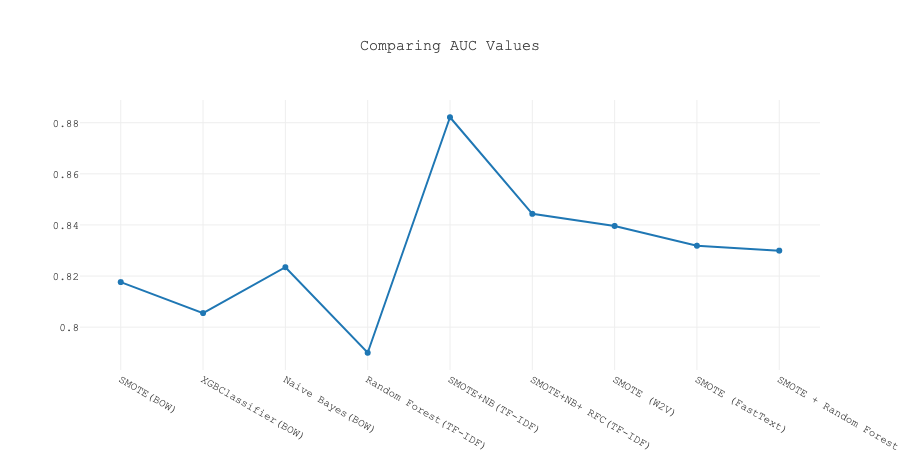

In [339]:
from IPython.display import Image
Image(filename="AUC.png")

In [332]:
lr_recall = metrics.recall_score(y_test, smote_predict) 
xgb_recall = metrics.recall_score(y_test, xgb_bow_prediction)
nb_recall = metrics.recall_score(y_test, nb_bow_predction)
rfc_recall = metrics.recall_score(y_test, rfc_tfid_prediction)
#eclf1_recall = metrics.recall_score(y_test , eclf1_predict)
eclf2_recall = metrics.recall_score(y_test , eclf2_predict)
eclf3_recall = metrics.recall_score(y_test, eclf3_predict)
#eclf4_recall  = metrics.recall_score(y_test, eclf4_predict)
smote_w2v_recall = metrics.recall_score(y_test, smote_w2v_predict)
smote_ft_recall = metrics.recall_score(y_test, smote_ft_predict)
ft_com_recall = metrics.recall_score(y_test, eclf6_predict)

In [340]:

import cufflinks as cf
import plotly
plotly.tools.set_credentials_file(username='nehrmegar', api_key='Ssb3HL4agEFKnGpftCV8')
import plotly.graph_objs as go
import plotly.plotly as py

data = [go.Line(
            x=['SMOTE(BOW)', 'XGBClassifier(BOW)', 'Naive Bayes(BOW)', 'Random Forest(TF-IDF)' , 
                'SMOTE+NB(TF-IDF)', 'SMOTE+NB+RFC(TF-IDF)','SMOTE (W2V)', 'SMOTE (FastText)', 'SMOTE + Random Forest(FastText)'],
            y=[lr_recall, xgb_recall, nb_recall, rfc_recall , eclf2_recall,eclf3_recall, smote_w2v_recall , smote_ft_recall , ft_com_recall]
    )]
layout = go.Layout(
    title = "Comparing Recall Values",
    font=dict(family='Courier New, monospace', size=11), 
    autosize=False,
    width=900,
    height=450)
fig = go.Figure(data=data,layout=layout )
py.iplot(fig , filename='basic-bar')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



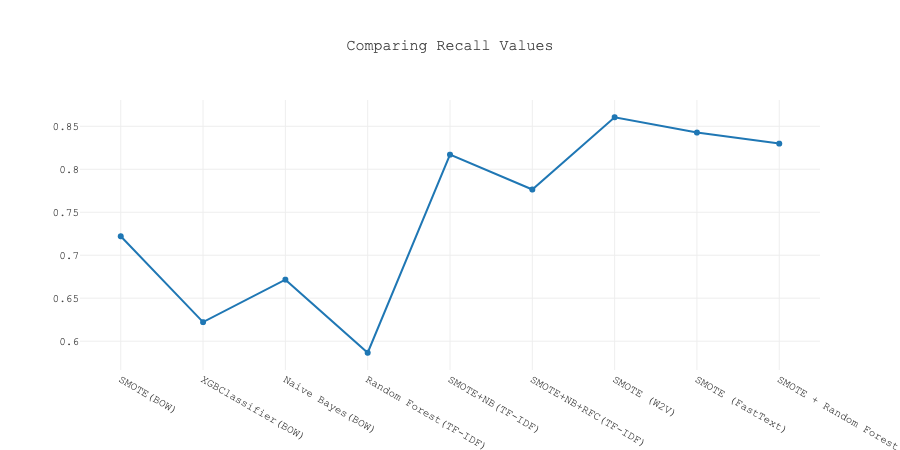

In [334]:
from IPython.display import Image
Image(filename="Recall.png")


### Even Though the combined model of Naive Bayes and SMOTE on TF-IDF has the highest AUC but our lowest number of False Negatives appear to be as the result of training  Logistic Regression - SMOTE on Word2Vec. Therefore our most optimized model is: 

### Logistic Regression - SMOTE with Word2Vec
#### Accuracy : 0.8229
#### Confusion Matrix: 
#### [[7359 1630]
#### [ 141  870]]
#### F1 score:  0.4955853033323839
#### Precision score:  0.348
#### Recall score:  0.8605341246290801


### Comparing Traditional and Neural Machine learning algorithms' ourputs

In [336]:
data = [go.Line(
                y = [lr_recall, xgb_recall,nb_recall,rfc_recall,eclf2_recall, eclf3_recall, smote_w2v_recall,
                     smote_ft_recall, ft_com_recall, 0.4075173095944609 , 0.3768545994065282 ], 

                x = ['SMOTE(BOW)', 'XGBClassifier(BOW)', 'Naive Bayes(BOW)', 'Random Forest(TF-IDF)','SMOTE+NB(TF-IDF)', 
                'SMOTE+NB+RFC(TF-IDF)', 'SMOTE (W2V)', 'SMOTE (FastText)', 'SMOTE + Random Forest(FastText)','Sequantial+adam+batch128' , 'Sequantial+tanh+batch64'])]

layout = go.Layout(
    title = "Comparing Recall Values Traditional and DNN",
    font=dict(family='Courier New, monospace', size=10), 
    autosize=False,
    width=900,
    height=450)
fig = go.Figure(data=data,layout=layout )
py.iplot(fig , filename='basic-bar')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



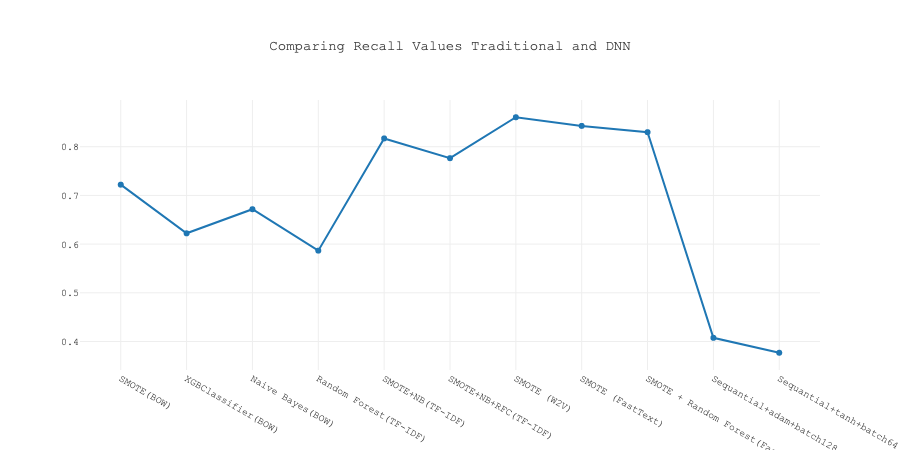

In [337]:
from IPython.display import Image
Image(filename="Combined-recall.png")